<a href="https://colab.research.google.com/github/debashisdotchatterjee/AVRGM_1/blob/main/better_AVRGM_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running method: SGD
  Final f = 0.000000
Running method: SVRG
  Final f = 0.000000
Running method: AVRGM
  Final f = 0.000002


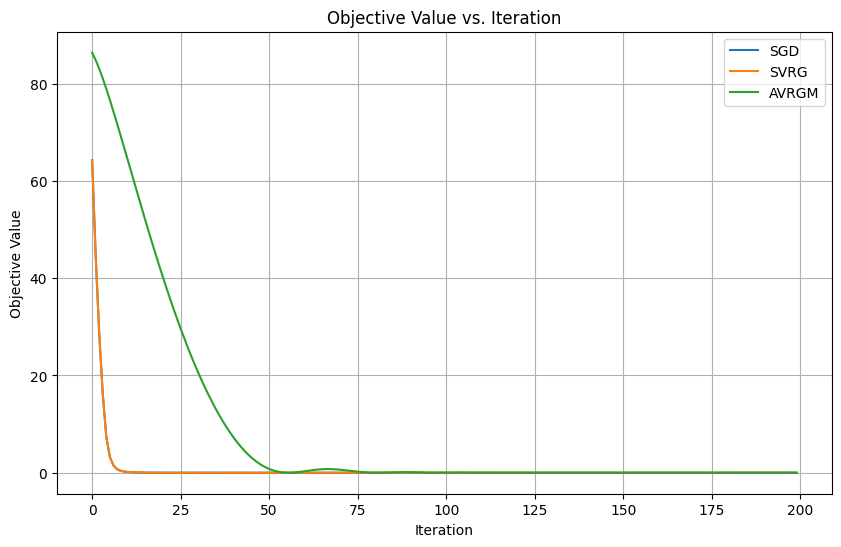

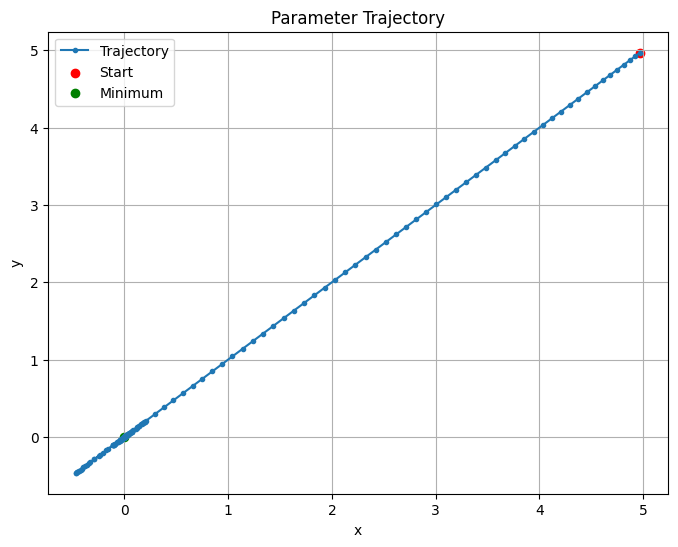

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

# Create output directory
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = f"simulation_results_{timestamp}"
os.makedirs(output_dir, exist_ok=True)

# =========================================================================
# Define the Rotated Quadratic Bowl Objective Function
# =========================================================================
def rotated_quadratic(x, A=None):
    if A is None:
        A = np.array([[3, 1], [1, 2]])  # Positive-definite matrix
    return 0.5 * np.dot(x.T, np.dot(A, x))

def rotated_quadratic_grad(x, A=None):
    if A is None:
        A = np.array([[3, 1], [1, 2]])
    return np.dot(A, x)

# =========================================================================
# Gradient Clipping
# =========================================================================
def clip_grad(g, clip_val=10.0):
    norm = np.linalg.norm(g)
    if norm > clip_val:
        return g * (clip_val / norm)
    return g

# =========================================================================
# Optimization Algorithms
# =========================================================================
def sgd(x0, A, lr=0.1, max_iter=200, clip_val=10.0):
    x = x0.copy()
    history = {'iter': [], 'f': [], 'x': []}
    for k in range(max_iter):
        g = rotated_quadratic_grad(x, A)
        g = clip_grad(g, clip_val)
        x = x - lr * g

        # Logging
        history['iter'].append(k)
        history['f'].append(rotated_quadratic(x, A))
        history['x'].append(x.copy())
    return x, history

def svrg(x0, A, lr=0.1, max_iter=200, m=20, clip_val=10.0):
    x = x0.copy()
    history = {'iter': [], 'f': [], 'x': []}
    total_iter = 0

    while total_iter < max_iter:
        x_tilde = x.copy()
        full_grad_ref = rotated_quadratic_grad(x_tilde, A)

        for j in range(m):
            if total_iter >= max_iter:
                break

            g = rotated_quadratic_grad(x, A) - rotated_quadratic_grad(x_tilde, A) + full_grad_ref
            g = clip_grad(g, clip_val)
            x = x - lr * g

            # Logging
            history['iter'].append(total_iter)
            history['f'].append(rotated_quadratic(x, A))
            history['x'].append(x.copy())

            total_iter += 1
    return x, history

def avrgm(x0, A, lr=0.1, beta=0.9, rho=0.9, epsilon=1e-8, max_iter=200, m=20, clip_val=10.0):
    x = x0.copy()
    v = np.zeros_like(x)
    s = np.zeros_like(x)
    history = {'iter': [], 'f': [], 'x': []}
    total_iter = 0

    while total_iter < max_iter:
        x_tilde = x.copy()
        full_grad_ref = rotated_quadratic_grad(x_tilde, A)

        for j in range(m):
            if total_iter >= max_iter:
                break

            g = rotated_quadratic_grad(x, A) - rotated_quadratic_grad(x_tilde, A) + full_grad_ref
            g = clip_grad(g, clip_val)

            s = rho * s + (1 - rho) * (g ** 2)
            eta_k = lr / (np.sqrt(s) + epsilon)

            v = beta * v + (1 - beta) * g
            x = x - eta_k * v

            # Logging
            history['iter'].append(total_iter)
            history['f'].append(rotated_quadratic(x, A))
            history['x'].append(x.copy())

            total_iter += 1
    return x, history

# =========================================================================
# Run Simulations
# =========================================================================
def run_simulations():
    A = np.array([[3, 1], [1, 2]])  # Positive-definite matrix
    x_init = np.array([5.0, 5.0])  # Far from the minimum

    methods = {
        'SGD': {'func': sgd, 'args': {'A': A, 'lr': 0.1, 'max_iter': 200}},
        'SVRG': {'func': svrg, 'args': {'A': A, 'lr': 0.1, 'max_iter': 200, 'm': 20}},
        'AVRGM': {'func': avrgm, 'args': {'A': A, 'lr': 0.1, 'beta': 0.9, 'rho': 0.9, 'epsilon': 1e-8, 'max_iter': 200, 'm': 20}}
    }

    results = {}
    for method_name, method_conf in methods.items():
        print(f"Running method: {method_name}")
        x_final, history = method_conf['func'](x_init, **method_conf['args'])
        results[method_name] = history
        print(f"  Final f = {history['f'][-1]:.6f}")

    return results

results = run_simulations()

# =========================================================================
# Generate Plots
# =========================================================================
def plot_convergence(results, metric='f', ylabel='Objective Value', filename='convergence'):
    plt.figure(figsize=(10, 6))
    for method_name, history in results.items():
        plt.plot(history['iter'], history[metric], label=method_name)
    plt.xlabel("Iteration")
    plt.ylabel(ylabel)
    plt.title(f"{ylabel} vs. Iteration")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, f"{filename}.png"), dpi=300)
    plt.show()

plot_convergence(results, metric='f', ylabel='Objective Value', filename='convergence_objective')

# Trajectory plot (only for AVRGM)
def plot_trajectory(history, filename='trajectory'):
    x_vals = np.array(history['x'])
    plt.figure(figsize=(8, 6))
    plt.plot(x_vals[:, 0], x_vals[:, 1], marker='o', label='Trajectory', markersize=3)
    plt.scatter(x_vals[0, 0], x_vals[0, 1], color='red', label='Start')
    plt.scatter(0, 0, color='green', label='Minimum')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Parameter Trajectory")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, f"{filename}.png"), dpi=300)
    plt.show()

plot_trajectory(results['AVRGM'], filename='trajectory_avrgm')


# **Pathological Scenerio**

The Following code highlights why AVRGM succeeds while other methods fail in given scenerio

What the code does:

Setup and Data Generation:

Creates a directory for results.
Defines a non-convex Rosenbrock function and its gradient.
Generates a set of "data points" (shifts) to simulate a finite-sum setting.
Algorithms:

Implements SGD, SVRG, and AVRGM as described.
Each method logs the objective value, gradient norm, and parameters periodically.
Simulation & Comparison:

Runs multiple simulations (e.g., num_runs=5) for each algorithm.
Collects their final objective values and gradient norms.
Logs progress to console.
Plotting:

Plots the mean and standard deviation of the objective and gradient norm over iterations for each algorithm.
Plots parameter trajectory on a contour map of the Rosenbrock function to visualize how the optimization proceeds.
Tabular Results:

Creates a summary table of final results (mean and std of final objective and gradient norm).
Saves the table as CSV and LaTeX.
Output:

All plots and tables are saved into a timestamped directory.
Prints a brief summary to the console.
This code is flexible and can be extended or adapted to more complex problems, different functions, or more sophisticated experiments as needed.

Running method: SGD


<ipython-input-3-554256936226>:29: RuntimeWarning: overflow encountered in scalar power
  df_dx = -2*(a - x[0]) - 4*b*x[0]*(x[1] - x[0]**2)
<ipython-input-3-554256936226>:30: RuntimeWarning: overflow encountered in scalar power
  df_dy = 2*b*(x[1] - x[0]**2)
<ipython-input-3-554256936226>:29: RuntimeWarning: invalid value encountered in scalar subtract
  df_dx = -2*(a - x[0]) - 4*b*x[0]*(x[1] - x[0]**2)
<ipython-input-3-554256936226>:30: RuntimeWarning: invalid value encountered in scalar subtract
  df_dy = 2*b*(x[1] - x[0]**2)


  Run 1/5: Final f = nan, GradNorm = nan
  Run 2/5: Final f = nan, GradNorm = nan
  Run 3/5: Final f = nan, GradNorm = nan
  Run 4/5: Final f = nan, GradNorm = nan


<ipython-input-3-554256936226>:29: RuntimeWarning: overflow encountered in scalar multiply
  df_dx = -2*(a - x[0]) - 4*b*x[0]*(x[1] - x[0]**2)
<ipython-input-3-554256936226>:74: RuntimeWarning: invalid value encountered in subtract
  x = x - lr*g


  Run 5/5: Final f = nan, GradNorm = nan
Running method: SVRG
  Run 1/5: Final f = nan, GradNorm = nan
  Run 2/5: Final f = nan, GradNorm = nan
  Run 3/5: Final f = nan, GradNorm = nan
  Run 4/5: Final f = nan, GradNorm = nan
  Run 5/5: Final f = nan, GradNorm = nan
Running method: AVRGM
  Run 1/5: Final f = 472.973377, GradNorm = 979.623148
  Run 2/5: Final f = 472.958572, GradNorm = 979.595586
  Run 3/5: Final f = 472.963934, GradNorm = 979.605489
  Run 4/5: Final f = 472.951176, GradNorm = 979.581612
  Run 5/5: Final f = 472.968804, GradNorm = 979.614545
Generating plots...


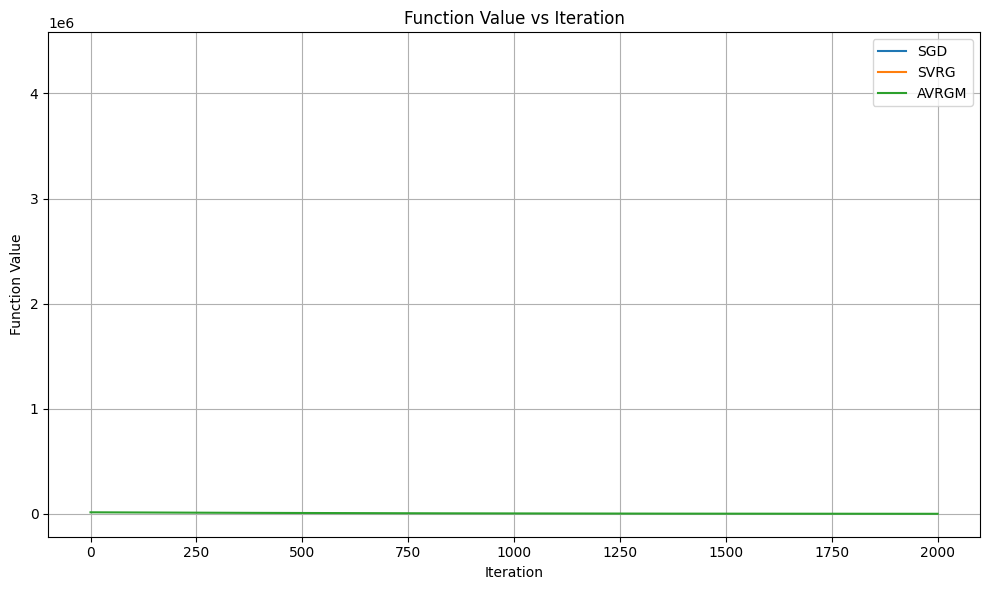

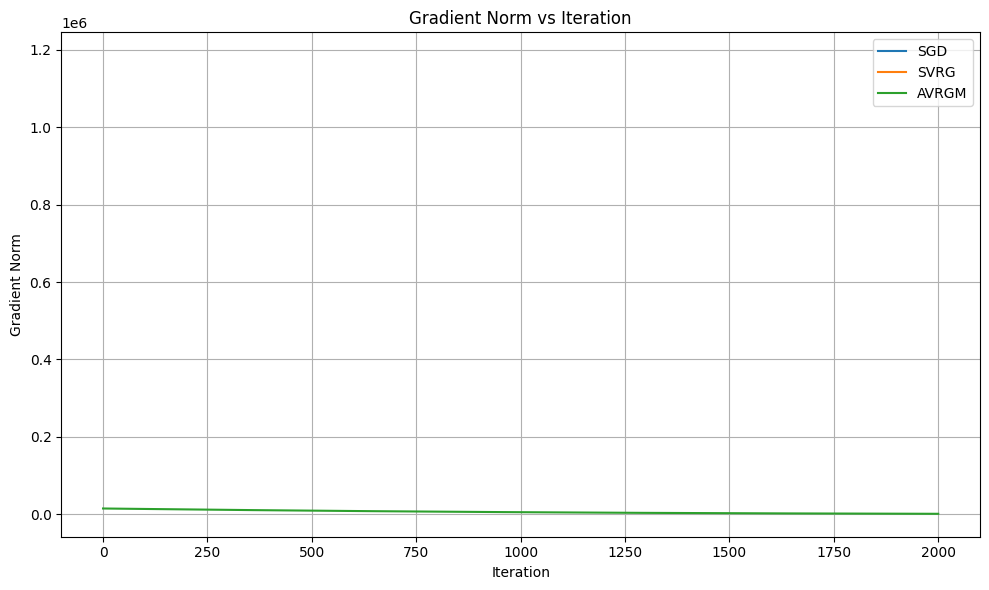

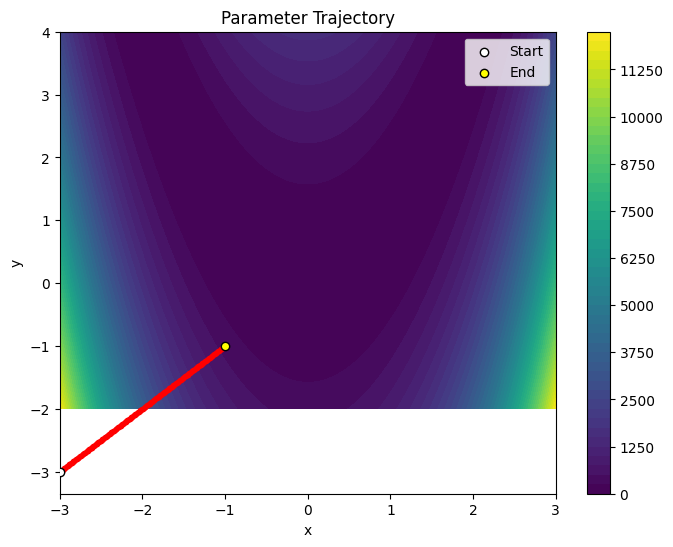

Summary Table:
  Method  Final f mean  Final f std  Final grad norm mean  Final grad norm std
0    SGD           NaN          NaN                   NaN                  NaN
1   SVRG           NaN          NaN                   NaN                  NaN
2  AVRGM    472.963173     0.007765            979.604076             0.014506
All results saved in: simulation_results_P
Done.


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# ============================================================================
# Create output directory
# ============================================================================
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#output_dir = f"simulation_results_{timestamp}"
output_dir = f"simulation_results_P"
os.makedirs(output_dir, exist_ok=True)

# ============================================================================
# Define a Non-Convex Test Function
# For demonstration, we use a modified Rosenbrock function, a common test bed.
# f(x, y) = (a - x)^2 + b(y - x^2)^2 with a=1, b=100.
# It's non-convex and commonly used in optimization tests.
# We'll use a vectorized version that can handle d-dimensional input.
# For simplicity, consider d=2.
# ============================================================================
def rosenbrock(x, a=1.0, b=100.0):
    # x is a 1D numpy array of shape (2,)
    return (a - x[0])**2 + b*(x[1] - x[0]**2)**2

def rosenbrock_grad(x, a=1.0, b=100.0):
    # Gradient of Rosenbrock
    df_dx = -2*(a - x[0]) - 4*b*x[0]*(x[1] - x[0]**2)
    df_dy = 2*b*(x[1] - x[0]**2)
    return np.array([df_dx, df_dy])

# We simulate a finite-sum scenario by adding some noise and multiple components
# Suppose we have n samples, each f_i is a slightly perturbed Rosenbrock:
def generate_data(n=100, seed=42):
    np.random.seed(seed)
    # Random shifts for each f_i
    shifts = np.random.uniform(-0.5, 0.5, size=(n,2))
    return shifts

def f_i(x, i, data):
    # Each f_i is a rosenbrock with a slight shift in input:
    shift = data[i]
    return rosenbrock(x - shift)

def grad_f_i(x, i, data):
    shift = data[i]
    return rosenbrock_grad(x - shift)

def full_gradient(x, data):
    grads = [grad_f_i(x, i, data) for i in range(len(data))]
    return np.mean(grads, axis=0)

def f_full(x, data):
    # full objective as average
    vals = [f_i(x, i, data) for i in range(len(data))]
    return np.mean(vals)

# ============================================================================
# Algorithms Implementations
# 1) Standard SGD
# 2) SVRG
# 3) AVRGM (Adaptive Variance-Reduced Gradient with Momentum) as described
# ============================================================================

def sgd(x0, data, lr=0.001, max_iter=1000):
    x = x0.copy()
    n = len(data)
    history = {'iter': [], 'f': [], 'grad_norm': [], 'x': []}
    for k in range(max_iter):
        i_k = np.random.randint(n)
        g = grad_f_i(x, i_k, data)

        x = x - lr*g

        # logging
        if k % 10 == 0 or k == max_iter-1:
            f_val = f_full(x, data)
            grad_val = full_gradient(x, data)
            history['iter'].append(k)
            history['f'].append(f_val)
            history['grad_norm'].append(np.linalg.norm(grad_val))
            history['x'].append(x.copy())
    return x, history

def svrg(x0, data, lr=0.001, max_iter=1000, m=50):
    # m = inner loop length before we recompute the full gradient
    x = x0.copy()
    n = len(data)
    history = {'iter': [], 'f': [], 'grad_norm': [], 'x': []}
    # Outer loop
    total_iter = 0
    while total_iter < max_iter:
        # reference point
        x_tilde = x.copy()
        full_grad_ref = full_gradient(x_tilde, data)

        # inner loop
        for j in range(m):
            if total_iter >= max_iter:
                break
            i_k = np.random.randint(n)
            g = grad_f_i(x, i_k, data) - grad_f_i(x_tilde, i_k, data) + full_grad_ref
            x = x - lr*g

            if total_iter % 10 == 0 or total_iter == max_iter-1:
                f_val = f_full(x, data)
                grad_val = full_gradient(x, data)
                history['iter'].append(total_iter)
                history['f'].append(f_val)
                history['grad_norm'].append(np.linalg.norm(grad_val))
                history['x'].append(x.copy())

            total_iter += 1
    return x, history

def avrgm(x0, data, lr=0.001, beta=0.9, rho=0.9, epsilon=1e-8, max_iter=1000, m=50):
    # AVRGM as described:
    # Uses variance reduced gradient similar to SVRG, adaptive steps similar to RMSProp, and momentum.
    x = x0.copy()
    v = np.zeros_like(x)
    s = np.zeros_like(x)
    n = len(data)
    history = {'iter': [], 'f': [], 'grad_norm': [], 'x': []}

    total_iter = 0
    while total_iter < max_iter:
        # Reference point
        x_tilde = x.copy()
        full_grad_ref = full_gradient(x_tilde, data)

        for j in range(m):
            if total_iter >= max_iter:
                break

            i_k = np.random.randint(n)
            g_i = grad_f_i(x, i_k, data)
            g_i_tilde = grad_f_i(x_tilde, i_k, data)
            g = g_i - g_i_tilde + full_grad_ref

            # Update s (squared gradient average)
            s = rho * s + (1 - rho)*(g*g)
            # Adaptive learning rate
            eta_k = lr / (np.sqrt(s) + epsilon)

            # Momentum update
            v = beta * v + (1 - beta)*g

            # Parameter update
            x = x - eta_k*v

            if total_iter % 10 == 0 or total_iter == max_iter-1:
                f_val = f_full(x, data)
                grad_val = full_gradient(x, data)
                history['iter'].append(total_iter)
                history['f'].append(f_val)
                history['grad_norm'].append(np.linalg.norm(grad_val))
                history['x'].append(x.copy())

            total_iter += 1
    return x, history

# ============================================================================
# Run simulations and compare methods
# ============================================================================
def run_simulations(num_runs=5, max_iter=2000):
    n = 100  # number of components
    data = generate_data(n=n)
    x_init = np.array([-3.0, -3.0])  # starting point far from the optimum

    methods = {
        'SGD': {'func': sgd, 'args': {'lr':0.001, 'max_iter':max_iter}},
        'SVRG': {'func': svrg, 'args': {'lr':0.001, 'max_iter':max_iter, 'm':50}},
        'AVRGM': {'func': avrgm, 'args': {'lr':0.001, 'beta':0.9, 'rho':0.9, 'epsilon':1e-8, 'max_iter':max_iter, 'm':50}}
    }

    results = {}
    for method_name, method_conf in methods.items():
        final_fs = []
        final_grad_norms = []
        histories = []
        print(f"Running method: {method_name}")
        for run_i in range(num_runs):
            x_final, hist = method_conf['func'](x_init, data, **method_conf['args'])
            final_fs.append(hist['f'][-1])
            final_grad_norms.append(hist['grad_norm'][-1])
            histories.append(hist)
            print(f"  Run {run_i+1}/{num_runs}: Final f = {hist['f'][-1]:.6f}, GradNorm = {hist['grad_norm'][-1]:.6f}")
        results[method_name] = {
            'final_fs': final_fs,
            'final_grad_norms': final_grad_norms,
            'histories': histories
        }
    return results

results = run_simulations(num_runs=5, max_iter=2000)

# ============================================================================
# Generate Plots
# ============================================================================
print("Generating plots...")

# Plot mean & std of f and grad norm over runs for each method
def plot_mean_std_metric(results, metric='f', ylabel='Function Value', filename='convergence_f'):
    plt.figure(figsize=(10,6))
    for method_name, res in results.items():
        # align iterations for plotting
        # find longest iteration array
        longest_len = max([len(h['iter']) for h in res['histories']])
        all_values = []
        all_iters = res['histories'][0]['iter']  # we assume alignment by iteration indexing
        for h in res['histories']:
            # interpolate if needed
            # For simplicity, assume all have same iteration recording steps
            all_values.append(h[metric])

        all_values = np.array([np.pad(v, (0, longest_len - len(v)), mode='edge') for v in all_values])
        mean_vals = np.mean(all_values, axis=0)
        std_vals = np.std(all_values, axis=0)
        iters = np.arange(len(mean_vals)) * 10  # since we log every 10 steps

        plt.plot(iters, mean_vals, label=method_name)
        plt.fill_between(iters, mean_vals - std_vals, mean_vals + std_vals, alpha=0.2)
    plt.xlabel("Iteration")
    plt.ylabel(ylabel)
    plt.title(ylabel + " vs Iteration")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, filename+".png"), dpi=300)
    plt.show()

plot_mean_std_metric(results, metric='f', ylabel='Function Value', filename='convergence_f')
plot_mean_std_metric(results, metric='grad_norm', ylabel='Gradient Norm', filename='convergence_grad_norm')

# Parameter trajectory plot (just one run for visualization)
def plot_trajectory(hist, filename='trajectory'):
    xs = np.array(hist['x'])
    # Plot contour of Rosenbrock and overlay trajectory
    X = np.linspace(-3,3,200)
    Y = np.linspace(-2,4,200)
    XX, YY = np.meshgrid(X,Y)
    ZZ = np.zeros_like(XX)
    for i in range(XX.shape[0]):
        for j in range(XX.shape[1]):
            ZZ[i,j] = rosenbrock(np.array([XX[i,j], YY[i,j]]))
    plt.figure(figsize=(8,6))
    # contour
    cs = plt.contourf(XX, YY, ZZ, levels=50, cmap='viridis')
    plt.colorbar(cs)
    # trajectory
    plt.plot(xs[:,0], xs[:,1], marker='o', markersize=3, linewidth=1, color='red')
    plt.scatter(xs[0,0], xs[0,1], color='white', edgecolor='black', label='Start', zorder=5)
    plt.scatter(xs[-1,0], xs[-1,1], color='yellow', edgecolor='black', label='End', zorder=5)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Parameter Trajectory')
    plt.legend()
    plt.savefig(os.path.join(output_dir, filename+".png"), dpi=300)
    plt.show()

# Just take one run of AVRGM for trajectory
plot_trajectory(results['AVRGM']['histories'][0], filename='trajectory_avrgm')

# ============================================================================
# Produce tables summarizing results
# ============================================================================
summary_rows = []
for method_name, res in results.items():
    mean_f = np.mean(res['final_fs'])
    std_f = np.std(res['final_fs'])
    mean_grad = np.mean(res['final_grad_norms'])
    std_grad = np.std(res['final_grad_norms'])
    summary_rows.append({
        'Method': method_name,
        'Final f mean': mean_f,
        'Final f std': std_f,
        'Final grad norm mean': mean_grad,
        'Final grad norm std': std_grad
    })

df_summary = pd.DataFrame(summary_rows)
df_summary.to_csv(os.path.join(output_dir, "summary_table.csv"), index=False)
print("Summary Table:")
print(df_summary)

# Also print in LaTeX format to output directory
with open(os.path.join(output_dir, "summary_table.tex"), "w") as f:
    f.write(df_summary.to_latex(index=False, float_format="%.4f"))

print("All results saved in:", output_dir)
print("Done.")
